In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
most_recent_date

'2017-08-23'

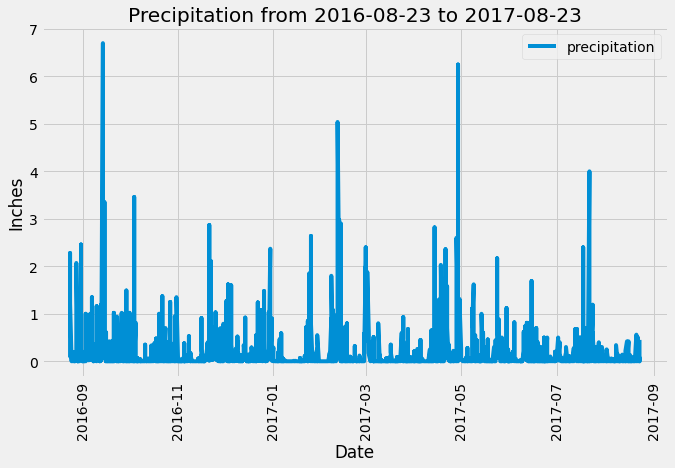

<Figure size 432x288 with 0 Axes>

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
date_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(date_prcp, columns = ['date', 'precipitation'])
prcp_df['date'] = pd.to_datetime(prcp_df['date'], format = '%Y-%m-%d')
prcp_df['date'] = prcp_df['date'].dt.date
prcp_df.set_index('date', inplace = True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by = 'date', ascending = True)
prcp_df = prcp_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(figsize=(10,6))
ax.set_title(f'Precipitation from {year_ago.date()} to {most_recent_date}')
ax.set_xlabel('Date')
ax.set_ylabel('Inches')

plt.xticks(rotation=90)
plt.show()

plt.savefig("Images/Precipitation_From_2016_2017.png")


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = prcp_df.describe()
stats

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(Station.station)).all()
num_stations

[(9,)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_count = (session.query(Measurement.station, func.count(Measurement.station)).
                  group_by(Measurement.station).
                  order_by(func.count(Measurement.station).desc()).all())
stations_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station?
most_active_station = stations_count[0][0]
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]           
session.query(*sel).filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

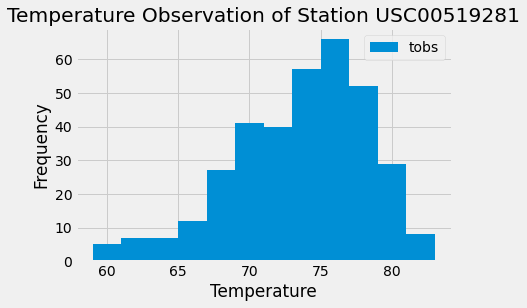

<Figure size 432x288 with 0 Axes>

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_st_last12mo = (session.query(Measurement.tobs).
             filter(Measurement.station == most_active_station).
             filter(Measurement.date >= year_ago).
             order_by(Measurement.date.desc()).all())

result = []
for index in range(len(most_active_st_last12mo)):
    result.append(most_active_st_last12mo[index][0])

plt.hist(result, bins=12)
plt.title(f'Temperature Observation of Station {most_active_station}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()

plt.savefig("Images/Temperature_Observation_of_Station.png")

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.
random_yr = calc_temps('2016-01-01', '2017-01-01')
random_yr

[(56.0, 74.1317494600432, 84.0)]

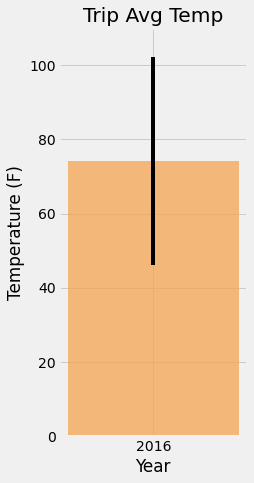

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = '2016'
y_avg = random_yr[0][1]
y_min = random_yr[0][0]
y_max = random_yr[0][2]
y_err = y_max - y_min

plt.figure(figsize=(3,7))
plt.bar(x, y_avg, yerr=y_err, color='#F6A452', alpha=0.75)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.xlabel('Year')
plt.ylim(0, 110)
plt.show()

plt.savefig("Images/Trip_Average_Temp.png")

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_date = dt.date(2015, 2 ,1)
end_trip_date = dt.date(2015, 2 ,15)

start_yr_prior_trip = (trip_date - dt.timedelta(days=365)).strftime('%Y-%m-%d')
end_yr_prior_trip = (end_trip_date - dt.timedelta(days=365)).strftime('%Y-%m-%d')

prcp_by_stations = (session.query(Measurement.station, func.sum(Measurement.prcp)).
                    filter(Measurement.date >= start_yr_prior_trip).filter(Measurement.date <= end_yr_prior_trip).
                    group_by(Measurement.station).
                    order_by(func.sum(Measurement.prcp).desc()).all())

stations_info = (session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).
                 group_by(Station.station).all())

prcp_by_stations_df = pd.DataFrame(prcp_by_stations, columns=['Station', 'Precipitation'])
stations_info_df = pd.DataFrame(stations_info, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])

merged_df = pd.merge(prcp_by_stations_df, stations_info_df, on='Station', how='inner')
merged_df

,Station,Precipitation,Name,Latitude,Longitude,Elevation
0,USC00519523,6.62,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,USC00516128,5.35,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,USC00519281,4.77,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00513117,3.58,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00514830,1.81,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,1.45,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00511918,0.96,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
7,USC00517948,0.35,"PEARL CITY, HI US",21.39340,-157.97510,11.9
8,USC00518838,0.00,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
start_date_formatted = datetime.strptime(start_date, "%Y-%m-%d")
end_date_formatted = datetime.strptime(end_date, "%Y-%m-%d")

date_list = []

period_in_days = end_date_formatted - start_date_formatted
num_of_days = period_in_days.days

for x in range(0, num_of_days +1):
    date_list.append(start_date_formatted + dt.timedelta(days=x))

# Stip off the year and save a list of %m-%d strings
date_list_no_year = []

for x in date_list:
    date_list_no_year.append(x.strftime('%m-%d'))

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []

for x in date_list_no_year:
    results = daily_normals(x)
    normals.append(results[0])

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates_df = pd.DataFrame(normals, columns =['Min Tem', 'Avg Temp', 'Max Temp'])
trip_dates_df['Days'] = date_list_no_year 
trip_dates_df['DATE'] = date_list
trip_dates_df = trip_dates_df.set_index('DATE') 
trip_dates_df

,Min Tem,Avg Temp,Max Temp,Days
DATE,,,,
2017-08-01,67.0,75.540000,83.0,08-01
2017-08-02,68.0,75.603774,84.0,08-02
2017-08-03,70.0,76.611111,85.0,08-03
2017-08-04,69.0,76.711538,84.0,08-04
2017-08-05,69.0,76.148148,82.0,08-05
2017-08-06,67.0,76.250000,83.0,08-06
2017-08-07,71.0,77.156863,83.0,08-07


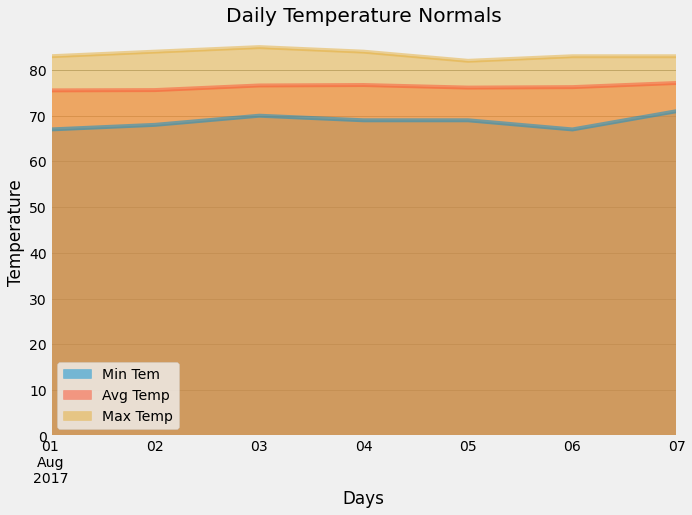

<Figure size 432x288 with 0 Axes>

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
trip_dates_df.plot.area(stacked=False, figsize=(10,7))
plt.grid(color='#9FA095', alpha=1)
plt.title('Daily Temperature Normals')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.show()

plt.savefig("Images/Daily_Temperature_Normals.png")
